In [1]:
# Import packages 
import sys
import argparse as arg

import time
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# import modules in other directories
sys.path.append('../Regridder/')
import scripGen as SG

import importlib
importlib.reload( SG )

#Rdry = Con.Rdry() # 



<module 'scripGen' from '/glade/work/juliob/PyRegridding/Drivers/../Regridder/scripGen.py'>

In [2]:
#####################################
myGridFiles = '/glade/work/juliob/GridFiles/'


In [3]:

L58f = f'{myGridFiles}/Vertical/GRID_48_taperstart10km_lowtop_BL10_v3p1_beta1p75.nc'
L32f = f'{myGridFiles}/Vertical/GRID_32L_CAM6.nc'



In [4]:
L32=xr.open_dataset( L32f )
L58=xr.open_dataset( L58f )

In [5]:
p32 = 100_000. * (L32.hybi+L32.hyai ).values
p58 = 100_000. * (L58.hybi+L58.hyai ).values

z32= -7_000. * np.log( p32/100_000. )
z58= -7_000. * np.log( p58/100_000. ) 
print( z58[58] )
dz58 = -( z58[1:59]-z58[0:58] )
dz32 = -( z32[1:33]-z32[0:32] )
zo58 = 0.5*( z58[1:59]+z58[0:58] )
zo32 = 0.5*( z32[1:33]+z32[0:32] )
print( z32[-9] )
print(z58[58-14])

-0.0
1593.9005479256305
1333.3732108965874


In [6]:
print( dz32 )

[5617.50067127 4917.50080314 4217.49989999 3300.90257372 1947.56378988
 1274.30446093 1239.39434006 1204.51385043 1323.31934985 1137.49960194
 1137.49882549 1137.49896028 1137.5001368  1137.49860019 1137.49951997
 1137.49947084 1137.4994805  1137.49974113 1137.49884386 1137.49962432
 1137.4993536   978.60063894  791.70026513  604.80029818  417.89915686
  231.00102788  210.00120984  188.99942474  168.00141339  146.99878509
  126.00131114  104.99821898]


In [7]:
dzXX = np.concatenate( [np.linspace(5500,1200,num=6),np.zeros(15)+1137.,np.linspace(1137.,dz58[57-17],num=5),dz58[58-16:58]] )

In [8]:
print(np.sum(dzXX ),np.sum(dz32 ),np.sum(dz58 ))

42371.42177994316 42661.493648361 43313.010950646465


In [9]:
nzXX  =len(dzXX)
nzXXe =len(dzXX)+1
zXX=np.zeros( nzXXe )
for L in np.arange( nzXXe-2, -1, -1):
    zXX[L]=zXX[L+1]+dzXX[L]

pXX = 100_000. * np.exp( -zXX/7_000.0 )

hyaiXX = np.interp( pXX , p58, L58.hyai.values )
hybiXX = pXX/100_000. -hyaiXX

hyamXX = np.zeros( nzXX )
hybmXX = np.zeros( nzXX )
zoXX = np.zeros( nzXX )

for L in np.arange( 0, nzXX, 1):
    hyamXX[L] = 0.5 * ( hyaiXX[L] + hyaiXX[L+1] )
    hybmXX[L] = 0.5 * ( hybiXX[L] + hybiXX[L+1] ) 
    zoXX[L]   = 0.5 * ( zXX[L]    + zXX[L+1] ) 


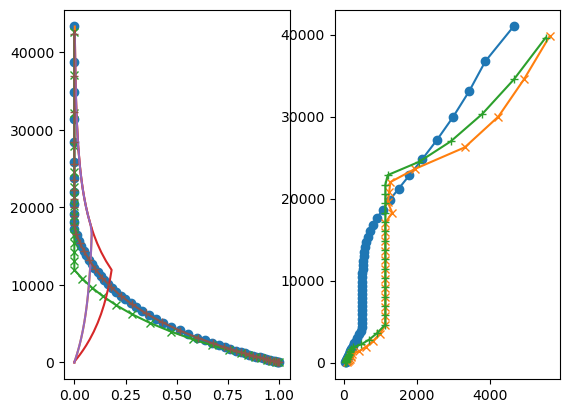

In [10]:
fig,ax=plt.subplots(1, 2, squeeze=False) 
ax[0,0].plot( L58.hybi ,z58,'-o')
ax[0,0].plot( L58.hyai ,z58)
ax[0,0].plot( L32.hybi ,z32,'-x')
ax[0,0].plot( L32.hyai ,z32)
ax[0,0].plot( hyaiXX ,zXX)
ax[0,0].plot( hybiXX ,zXX,'-+')

ax[0,1].plot( dz58,zo58,'-o')
ax[0,1].plot( dz32,zo32,'-x')
ax[0,1].plot( dzXX,zoXX,'-+')


In [11]:
ilev = (hyaiXX + hybiXX ) * 1_000. #* 100_000.
lev  = (hyamXX + hybmXX ) * 1_000. #* 100_000.


dims   = ["lev","ilev"]
coords = dict( 
    lev  = ( ["lev"],lev),
    ilev = ( ["ilev"],ilev),
)


NewVgrid = xr.Dataset( coords=coords  )

Dar = xr.DataArray( data=hyaiXX, dims=('ilev',),
                    attrs=dict( description='interface hybrid eta coordinate A-coeff ',units='1',) ,) 
NewVgrid['hyai'] = Dar

Dar = xr.DataArray( data=hybiXX, dims=('ilev',),
                    attrs=dict( description='interface hybrid eta coordinate B-coeff ',units='1',) ,) 
NewVgrid['hybi'] = Dar

Dar = xr.DataArray( data=hyamXX, dims=('lev',),
                    attrs=dict( description='mid-level hybrid eta coordinate A-coeff ',units='1',) ,) 
NewVgrid['hyam'] = Dar

Dar = xr.DataArray( data=hybmXX, dims=('lev',),
                    attrs=dict( description='mid-level hybrid eta coordinate B-coeff ',units='1',) ,) 
NewVgrid['hybm'] = Dar

newname = f'{myGridFiles}/GRID_{str(nzXX)}L_CAM7.nc'

NewVgrid.to_netcdf( newname )

In [12]:
print(newname)

/glade/work/juliob/GridFiles//GRID_42L_CAM7.nc
